In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [2]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

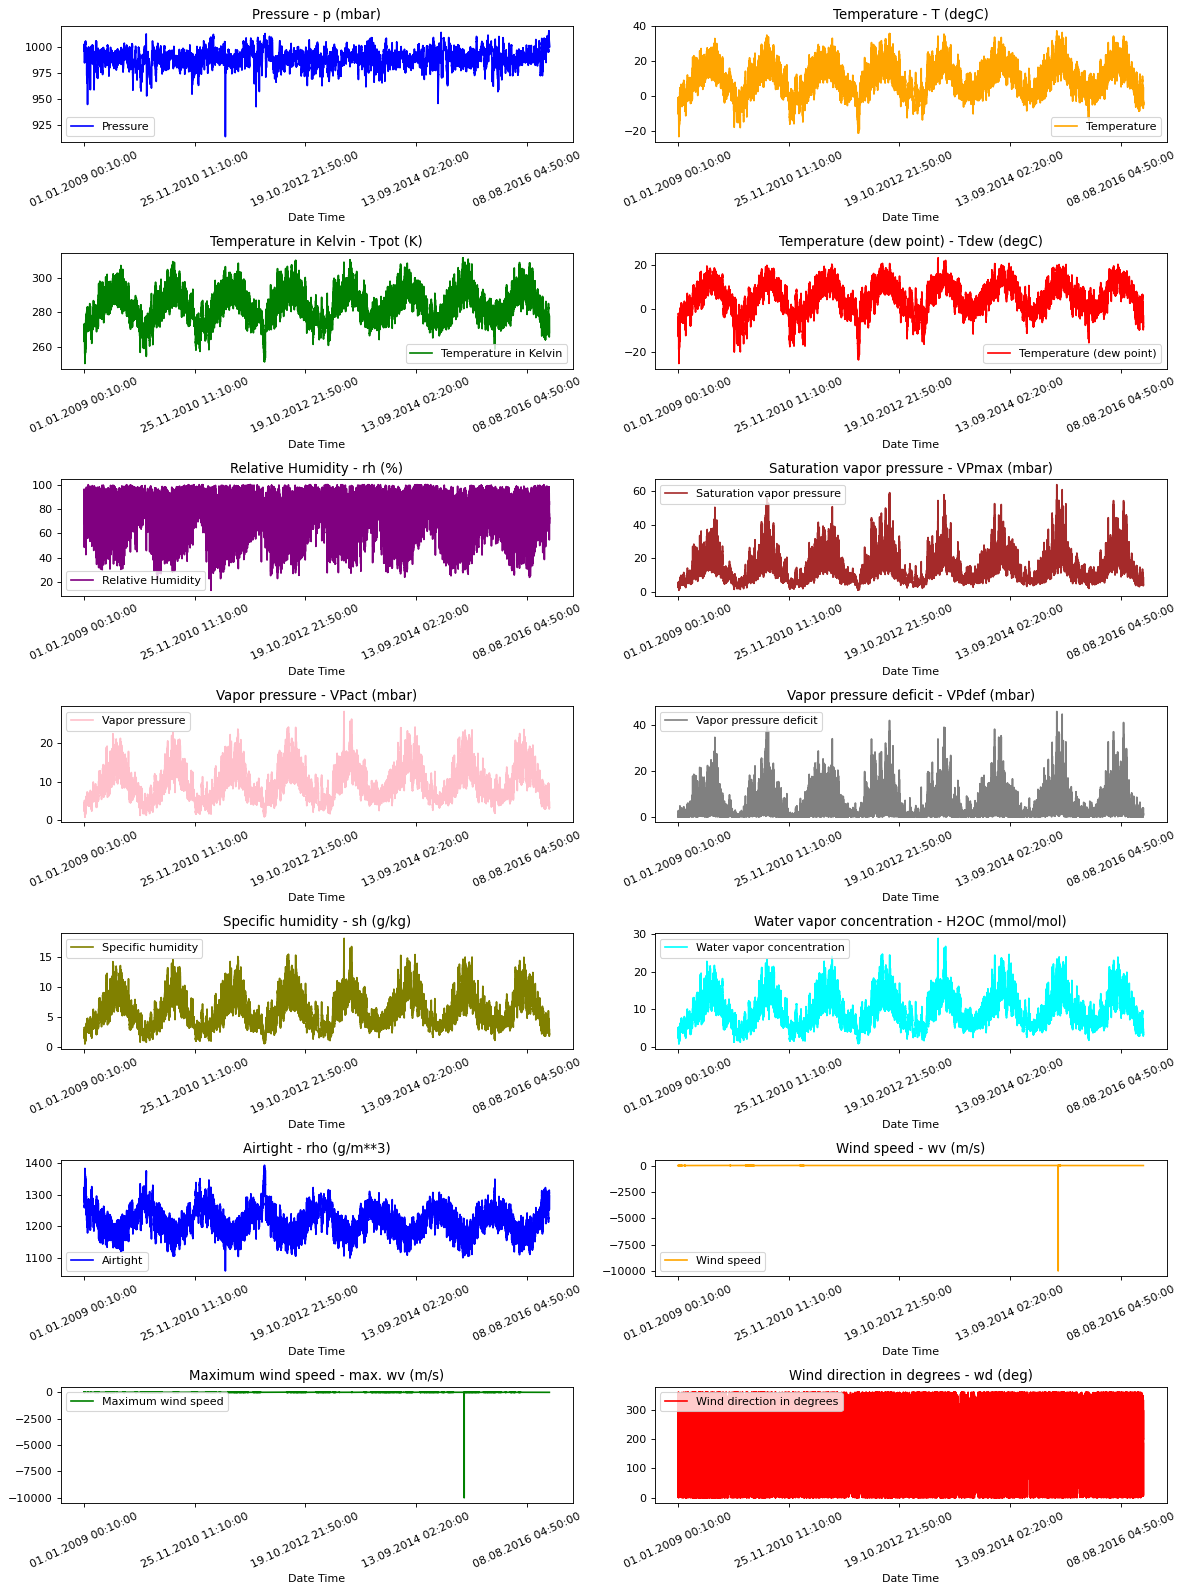

In [10]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

In [11]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [12]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [13]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [14]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [15]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(10):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


In [16]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(64)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.01,
    rho=0.6,
    momentum=0.0,
    epsilon=1e-08,
    centered=True), loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 7)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                18432     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0
_________________________________________________________________


In [17]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.2045
Epoch 00001: val_loss improved from inf to 0.70291, saving model to model_checkpoint.h5
1172/1172 [==============================] - 163s 139ms/step - loss: 0.2045 - val_loss: 0.7029
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1840
Epoch 00002: val_loss improved from 0.70291 to 0.65110, saving model to model_checkpoint.h5
1172/1172 [==============================] - 148s 126ms/step - loss: 0.1840 - val_loss: 0.6511
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1771
Epoch 00003: val_loss did not improve from 0.65110
1172/1172 [==============================] - 149s 127ms/step - loss: 0.1771 - val_loss: 1.0641
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.1943
Epoch 00004: val_loss did not improve from 0.65110
1172/1172 [==============================] - 150s 128ms/step - loss: 0.1943 - val_loss: 1.2332
Epoch 5/10
1172/1172 [

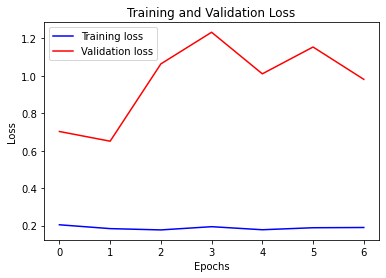

In [18]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

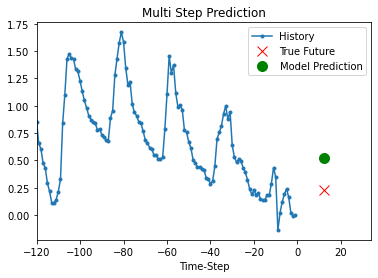

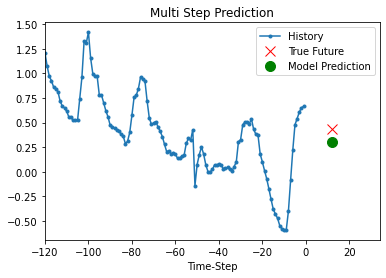

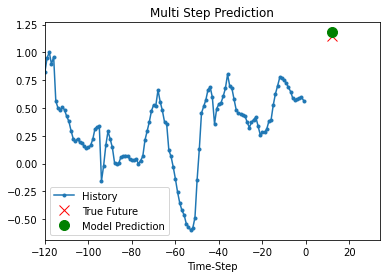

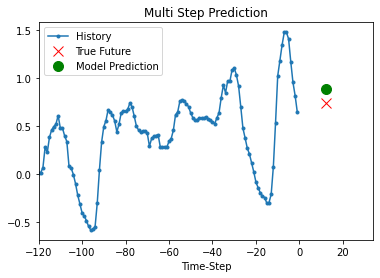

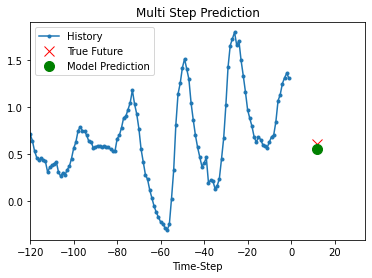

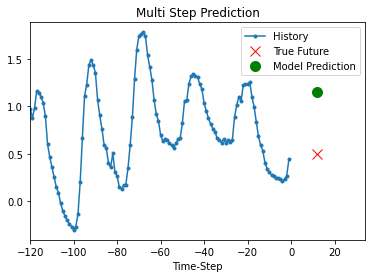

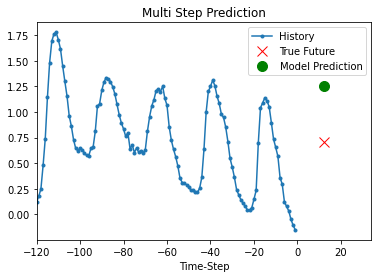

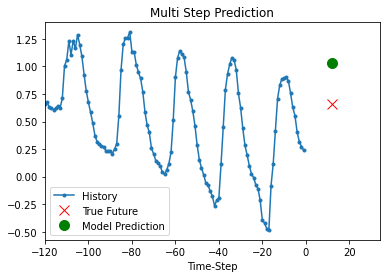

In [19]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(8):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Multi Step Prediction",
    )

